# Mountain Car Q Value Approximation

![mountain_car_0](../images/lecture_3/mountain_car_0.png)

![mountain_car_1](../images/lecture_3/mountain_car_1.png)

![mountain_car_2](../images/lecture_3/mountain_car_2.png)


## Gym Description

### Description

The Mountain Car MDP is a deterministic MDP that consists of a car placed stochastically
at the bottom of a sinusoidal valley, with the only possible actions being the accelerations
that can be applied to the car in either direction. The goal of the MDP is to strategically
accelerate the car to reach the goal state on top of the right hill. There are two versions
of the mountain car domain in gymnasium: one with discrete actions and one with continuous.
This version is the one with discrete actions.

This MDP first appeared in [Andrew Moore's PhD Thesis (1990)](https://www.cl.cam.ac.uk/techreports/UCAM-CL-TR-209.pdf)

```
@TECHREPORT{Moore90efficientmemory-based,
    author = {Andrew William Moore},
    title = {Efficient Memory-based Learning for Robot Control},
    institution = {University of Cambridge},
    year = {1990}
}
```

### Observation Space

The observation is a `ndarray` with shape `(2,)` where the elements correspond to the following:

| Num | Observation                          | Min   | Max  | Unit         |
| --- | ------------------------------------ | ----- | ---- | ------------ |
| 0   | position of the car along the x-axis | -1.2  | 0.6  | position (m) |
| 1   | velocity of the car                  | -0.07 | 0.07 | velocity (v) |

### Action Space

There are 3 discrete deterministic actions:

- 0: Accelerate to the left
- 1: Don't accelerate
- 2: Accelerate to the right

### Transition Dynamics:

Given an action, the mountain car follows the following transition dynamics:

_velocity<sub>t+1</sub> = velocity<sub>t</sub> + (action - 1) _ force - cos(3 _ position<sub>t</sub>) _ gravity\*

_position<sub>t+1</sub> = position<sub>t</sub> + velocity<sub>t+1</sub>_

where force = 0.001 and gravity = 0.0025. The collisions at either end are inelastic with the velocity set to 0
upon collision with the wall. The position is clipped to the range `[-1.2, 0.6]` and
velocity is clipped to the range `[-0.07, 0.07]`.

### Reward:

The goal is to reach the flag placed on top of the right hill as quickly as possible, as such the agent is
penalised with a reward of -1 for each timestep.

### Starting State

The position of the car is assigned a uniform random value in _[-0.6 , -0.4]_.
The starting velocity of the car is always assigned to 0.

### Episode End

The episode ends if either of the following happens:

1. Termination: The position of the car is greater than or equal to 0.5 (the goal position on top of the right hill)
2. Truncation: The length of the episode is 200.

### Arguments

```python
import gymnasium as gym
gym.make('MountainCar-v0')
```

On reset, the `options` parameter allows the user to change the bounds used to determine
the new random state.

### Version History

- v0: Initial versions release (1.0.0)


## Import Env

In [12]:
import gymnasium as gym
for k,v in gym.envs.registry.items():
    print(k,"\t",v)

CartPole-v0 	 EnvSpec(id='CartPole-v0', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=195.0, nondeterministic=False, max_episode_steps=200, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='CartPole', version=0, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv')
CartPole-v1 	 EnvSpec(id='CartPole-v1', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='CartPole', version=1, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv')
MountainCar-v0 	 EnvSpec(id='MountainCar-v0', entry_point='gymnasium.envs.classic_control.mountain_car:MountainCarEnv', reward_threshold

In [13]:
from gymnasium.envs.classic_control.mountain_car import MountainCarEnv
env=gym.make("MountainCar-v0")
print("Observation space: ",env.observation_space)
print("Action space: ",env.action_space)

Observation space:  Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Action space:  Discrete(3)


## Normalizer

In [14]:
import numpy as np


def normalizer(env: gym.Env, state: np.ndarray):
    LOW = env.observation_space.low
    HIGH = env.observation_space.high
    normalized_state = np.zeros(state.shape)
    normalized_state = (state-LOW)/(HIGH - LOW)
    return normalized_state


normalizer(env, env.reset()[0])


array([0.35358536, 0.5       ], dtype=float32)

## Q Approximator

In [15]:
import torch
import torch.nn as nn


class Q_Approximator(nn.Module):
    def __init__(self, num_observations: int, num_actions: int) -> None:
        super().__init__()
        self.layer_1 = nn.Linear(num_observations, 128)
        self.layer_2 = nn.Linear(128, num_actions)
        self.selu = nn.SELU()

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        q_actions = self.layer_1(state)
        q_actions = self.selu(q_actions)
        q_actions = self.layer_2(q_actions)
        return q_actions


## Experience

In [16]:
from collections import namedtuple, deque
from typing import List
import random
Transition = namedtuple(
    "transition", ["state", "action", "next_state", "next_action", "reward"])


class Experience:
    def __init__(self, maxlen: int) -> None:
        self.experience = deque([], maxlen)

    def append(self, transition: Transition):
        self.experience.append(transition)

    def sample(self, batch_size) -> List:
        return random.sample(self.experience, batch_size)

    def get_length(self) -> int:
        return len(self.experience)


## Epsilon Decay

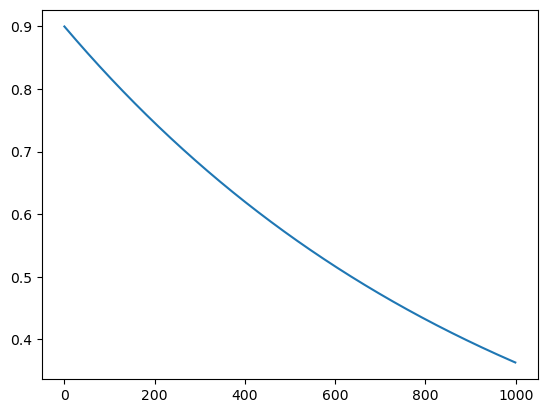

In [17]:
import numpy as np


def get_epsilon(epsilon_start: float, epsilon_end: float, num_episodes: float, step_i: int):
    """return epsilon=epsilon_end+(epsilon_start-epsilon_end)*decay_rate**step_decay"""
    epsilon = epsilon_end+(epsilon_start-epsilon_end) * \
        np.exp(-1.0*step_i/num_episodes)
    return epsilon


def plot_epsilon(epsilon_start: float, epsilon_end: float, num_episode: float):
    import matplotlib.pyplot as plt
    xs = np.arange(num_episode)
    epsilons = np.array(
        [get_epsilon(epsilon_start, epsilon_end, num_episode, step) for step in xs])
    plt.plot(xs, epsilons)


plot_epsilon(0.9, 0.05, int(1e3))


## Epsilon-greedy

In [18]:
def epsilon_greedy(policy_net: Q_Approximator, num_actions: int, state: torch.Tensor, epsilon: float) -> int:
    probability = 1.0*np.ones(num_actions)*epsilon/num_actions
    q_actions = policy_net(state).detach().cpu().numpy()
    idx_action_with_max_q = np.argmax(q_actions)
    probability[idx_action_with_max_q] = 1-np.sum(probability[1:])
    return np.random.choice(np.arange(num_actions), p=probability)


epsilon_greedy(Q_Approximator(env.observation_space.shape[0], env.action_space.n), env.action_space.n, torch.tensor(
    env.reset()[0], dtype=torch.float32), 0.1)


1

## Learning Rate Decay

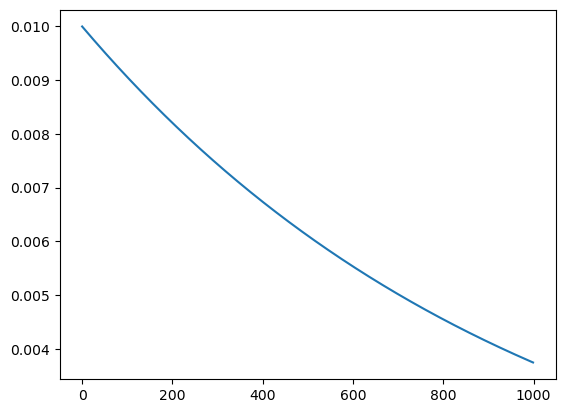

In [19]:
def get_learning_rate(learning_rate_start:float,learning_rate_end:float,num_episodes:float,step_i:int):
    """return epsilon=epsilon_end+(epsilon_start-epsilon_end)*decay_rate**step_decay"""
    learning_rate=learning_rate_end+(learning_rate_start-learning_rate_end)*np.exp(-1.0*step_i/num_episodes)
    return learning_rate

def plot_learning_rate(epsilon_start: float, epsilon_end: float, num_episode: float):
    import matplotlib.pyplot as plt
    xs = np.arange(num_episode)
    lrs = np.array(
        [get_epsilon(epsilon_start, epsilon_end, num_episode, step) for step in xs])
    plt.plot(xs, lrs)


plot_epsilon(1e-2, 1e-4, int(1e3))

In [20]:
def q_learning_update_policy_net(policy_net:Q_Approximator,target_net:Q_Approximator,
                                experience:Experience,batch_size:int,
                                learning_rate:float,gamma:float,
                                loss_fn:nn.Module,optimizer:torch.optim.Optimizer,
                                device:str):
    
    # set up learning rate
    for g in optimizer.param_groups:
        g['lr']=learning_rate
    
    batch=experience.sample(batch_size)
    [batch_state,batch_action,batch_next_state,batch_next_action,batch_reward]=zip(*batch)
    batch_state=torch.tensor(batch_state,dtype= torch.float32,device= device)
    batch_action=torch.tensor(batch_action,dtype= torch.int64,device= device).unsqueeze(-1)
    mask_batch_next_state_is_not_none=torch.tensor([next_state is not None for next_state in batch_next_state],dtype= torch.bool,device=device)
    batch_not_none_next_state=torch.tensor([next_state for next_state in batch_next_state if next_state is not None],dtype= torch.float32,device= device)
    batch_reward=torch.tensor(batch_reward,dtype= torch.float32,device= device).unsqueeze(-1)
    
    q_state_action=policy_net(batch_state).gather(1,batch_action)
    q_next_state_action=torch.zeros(q_state_action.size(),device=device)
    with torch.no_grad():
        q_next_state_action[mask_batch_next_state_is_not_none]=target_net(batch_not_none_next_state).max(1)[0].unsqueeze(-1)
    q_target=batch_reward+gamma*q_next_state_action
    
    optimizer.zero_grad()
    loss=loss_fn(q_state_action,q_target)
    loss.backward()
    optimizer.step()
    
    return loss.item()
    

## Q Learning

In [21]:
from collections import defaultdict


def q_learning(env: gym.Env, num_episodes: int = int(1e3),
               experience_maxlen: int = 2**10, batch_size: int = 64,
               gamma: float = 0.9,
               learning_rate_start: float = 1e-3, learning_rate_end: float = 1e-4,
               epsilon_start: float = 0.9, epsilon_end: float = 0.05,
               tau=0.005,
               device: str = "cpu",
               print_step: int = 100):
    policy_net = Q_Approximator(
        env.observation_space.shape[0], env.action_space.n).to(device)
    target_net = Q_Approximator(
        env.observation_space.shape[0], env.action_space.n).to(device)

    loss_fn = nn.MSELoss()
    optimizer = torch.optim.SGD(policy_net.parameters(), learning_rate_start)

    experience = Experience(experience_maxlen)

    num_attempts_per_episode = defaultdict(int)
    reward_per_episode = defaultdict(float)

    loss = 0.0

    for episode_i in range(num_episodes):
        state = env.reset()[0]
        is_terminated = False
        epsilon = get_epsilon(epsilon_start, epsilon_end,
                              num_episodes, episode_i)
        learning_rate = get_learning_rate(
            learning_rate_start, learning_rate_end, num_episodes, episode_i)
        while not is_terminated:
            normalized_state = normalizer(env, state)
            action = epsilon_greedy(policy_net, env.action_space.n, torch.tensor(
                normalized_state, dtype=torch.float32, device=device), epsilon)
            next_state, reward, is_terminated, is_truncated, info = env.step(
                action)
            normalized_next_state = normalizer(env, next_state)
            if is_terminated:
                next_state = None
            experience.append(Transition(
                normalized_state, action, normalized_next_state, None, reward))
            
            state=next_state
            
            if experience.get_length() >= batch_size:
                loss = q_learning_update_policy_net(
                    policy_net, target_net, experience, batch_size, learning_rate, gamma, loss_fn, optimizer, device)

                target_net_state_dict = target_net.state_dict()
                policy_net_state_dict = policy_net.state_dict()
                for key in policy_net_state_dict:
                    target_net_state_dict[key] = policy_net_state_dict[key] * \
                        tau + target_net_state_dict[key]*(1-tau)
                target_net.load_state_dict(target_net_state_dict)

            num_attempts_per_episode[episode_i] += 1
            reward_per_episode[episode_i] += reward

        if episode_i % print_step == 0:
            print("episode %d, loss %f, num_attempts %d" %
                  (episode_i, loss, num_attempts_per_episode[episode_i]))

    return policy_net, num_attempts_per_episode, reward_per_episode


In [22]:
q_learning_policy_net,q_learning_num_attempts_per_episode,q_learning_reward_per_episode=q_learning(env,num_episodes=int(1e3),experience_maxlen=2**10,batch_size=64,gamma=0.9,learning_rate_start=1e-6,learning_rate_end=1e-7,epsilon_start=0.9,epsilon_end=0.05,tau=0.005,device="cuda" if torch.cuda.is_available() else "cpu",print_step=1)

episode 0, loss 0.721088, num_attempts 9722
episode 1, loss 0.688925, num_attempts 5704
episode 2, loss 0.726391, num_attempts 4434
episode 3, loss 0.707658, num_attempts 4994
episode 4, loss 0.756110, num_attempts 494
episode 5, loss 0.707315, num_attempts 2464
episode 6, loss 0.729528, num_attempts 755
episode 7, loss 0.762063, num_attempts 2800
episode 8, loss 0.749228, num_attempts 2232
episode 9, loss 0.733780, num_attempts 2042
episode 10, loss 0.688048, num_attempts 2290
episode 11, loss 0.741012, num_attempts 1054
episode 12, loss 0.716736, num_attempts 1647
episode 13, loss 0.703484, num_attempts 2258
episode 14, loss 0.692307, num_attempts 1409
episode 15, loss 0.706655, num_attempts 2967
episode 16, loss 0.693902, num_attempts 1464
episode 17, loss 0.682548, num_attempts 3872
episode 18, loss 0.678716, num_attempts 1197
episode 19, loss 0.663874, num_attempts 2233
episode 20, loss 0.669285, num_attempts 1602
episode 21, loss 0.692301, num_attempts 887
episode 22, loss 0.6759

## Save the Result

In [23]:
torch.save(q_learning_policy_net.state_dict(),"saves/MountainCar-v0.pth")

## Plot Train Result

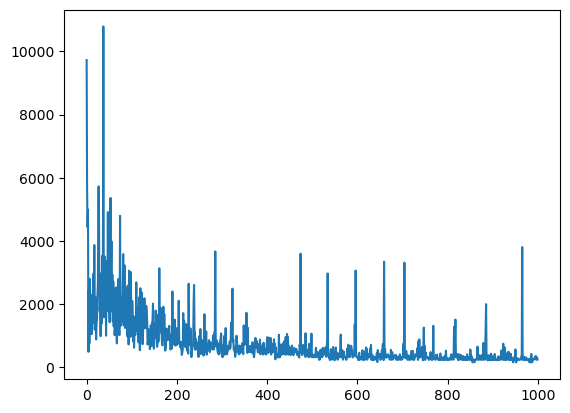

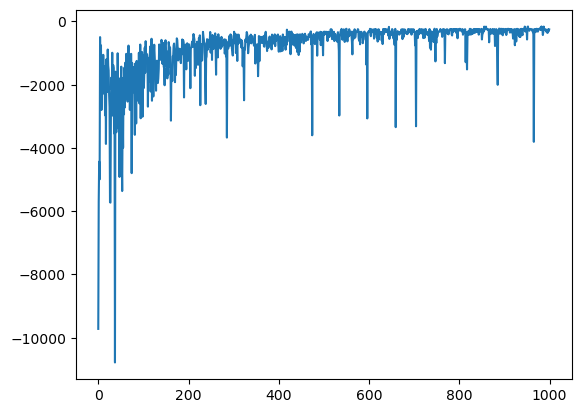

In [24]:
import matplotlib.pyplot as plt
from typing import Dict
def plot_num_attempts_per_episode(num_attempts_per_episode:Dict):
    fig,ax=plt.subplots()
    ax.plot(num_attempts_per_episode.keys(),num_attempts_per_episode.values())
    
def plot_reward_per_episode(reward_per_episode:Dict):
    fig,ax=plt.subplots()
    ax.plot(reward_per_episode.keys(),reward_per_episode.values())
    
plot_num_attempts_per_episode(q_learning_num_attempts_per_episode)
plot_reward_per_episode(q_learning_reward_per_episode)

## Test the Policy

In [33]:
def test_policy(env: gym.Env, policy_net: Q_Approximator, num_tests: int, device: str):
    num_attempts = []
    for test_i in range(num_tests):
        state = env.reset()[0]
        num_trying_step = 0
        is_terminated = False
        while not is_terminated:
            normalized_state = normalizer(env, state)
            q_actions = torch.zeros((env.action_space.n, 1))
            with torch.no_grad():
                q_actions = policy_net(torch.tensor(
                    normalized_state, dtype=torch.float32, device=device))
            action = torch.argmax(q_actions).detach().cpu().item()
            state, reward, is_terminated, is_truncated, info = env.step(action)
            num_trying_step += 1
        num_attempts.append(num_trying_step)
        print("test %d, take %d steps" % (test_i, num_trying_step))
    print("Average trying step :%f" % (1.0*np.sum(num_attempts)/num_tests))


test_policy(env, q_learning_policy_net, int(1e3),
            device="cuda" if torch.cuda.is_available() else "cpu")


test 0, 163 steps
test 1, 162 steps
test 2, 162 steps
test 3, 163 steps
test 4, 162 steps
test 5, 161 steps
test 6, 164 steps
test 7, 162 steps
test 8, 164 steps
test 9, 163 steps
test 10, 164 steps
test 11, 163 steps
test 12, 165 steps
test 13, 162 steps
test 14, 165 steps
test 15, 165 steps
test 16, 164 steps
test 17, 162 steps
test 18, 162 steps
test 19, 163 steps
test 20, 162 steps
test 21, 166 steps
test 22, 163 steps
test 23, 162 steps
test 24, 163 steps
test 25, 164 steps
test 26, 162 steps
test 27, 163 steps
test 28, 163 steps
test 29, 163 steps
test 30, 161 steps
test 31, 164 steps
test 32, 162 steps
test 33, 161 steps
test 34, 163 steps
test 35, 163 steps
test 36, 164 steps
test 37, 164 steps
test 38, 162 steps
test 39, 163 steps
test 40, 163 steps
test 41, 163 steps
test 42, 162 steps
test 43, 164 steps
test 44, 162 steps
test 45, 163 steps
test 46, 162 steps
test 47, 165 steps
test 48, 163 steps
test 49, 164 steps
test 50, 163 steps
test 51, 162 steps
test 52, 164 steps
tes